In [36]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from minimization import SolverLLS
import classes_minim as minim

Dataset size = (5875, 22)
Dataset features count = 22


<Axes: ylabel='Frequency'>

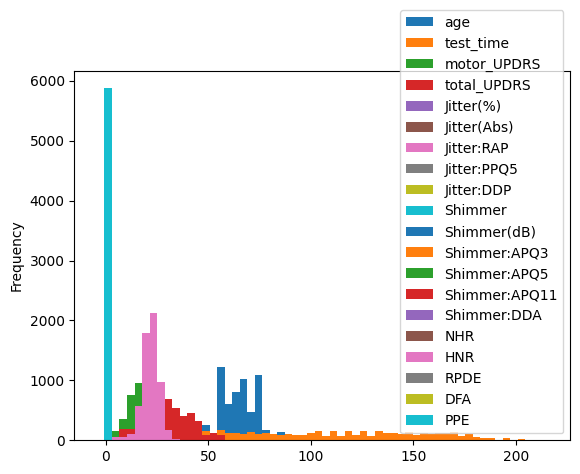

In [37]:
x = pd.read_csv("parkinsons_updrs.csv")
features = x.columns  # first columns will contain the names of the features
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')
# print(features)


# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(bins=60)  # 'subject#' and 'sex' are removed to have a crearer histogram
# bins is the number of rectangles, so the lesser -> the more values will be represented with a single rectangle

In [48]:
#AVARAGE VALUES OF VOICE PARAMETERS IN ONE DAY
# Loop through each subject ID
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:  # for each subject#
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()
    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']  # new property called 'g' containing the 'test_time' property
    # now the dataframe collapses using 'g' as pivot, and computing the mean for each other property
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along rows. (0, 1) -> (rows, columns)
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')



X shape = (990, 22)


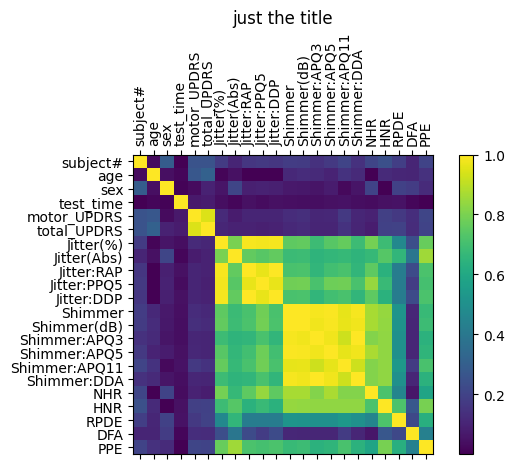

In [39]:

"""test time has large covariance, so makes other values too small to be seen, so we want to see the correlation coefficent"""
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

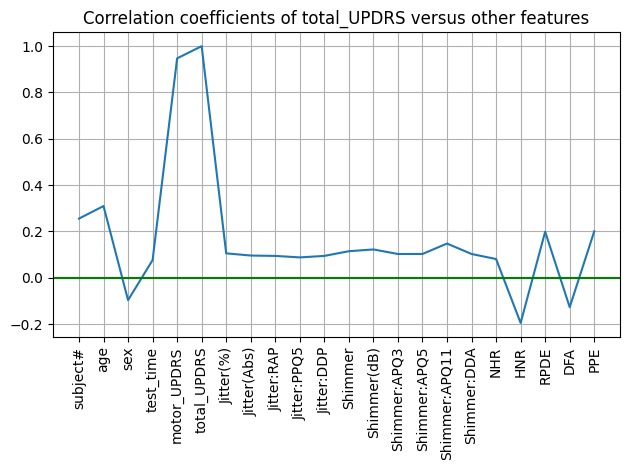

'obviously motor e total updrs are highly correlated (it is a part of it), we can even see that there is a correlation between subject e total updrs, but it is not correct use it as regressor (it is random)'

In [50]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

"""obviously motor e total updrs are highly correlated (it is a part of it), we can even see that there is a correlation between subject e total updrs, but it is not correct use it as regressor (it is random)"""

In [51]:
seed = 30
# Shuffling is needed to avoid that only data from the first patient is used for the training. This is
# to pretend that all the measurements are taken from different patients in different stages of the illness.
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)


In [52]:
Ntr = int(Np * 0.5)  # Number of training points
Nte = Np - Ntr  # Number of test points
X_tr = Xsh[:Ntr]
mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values
Xsh_norm = (Xsh - mm_vals) / ss_vals  # normalization of all parameters
ysh_norm = Xsh_norm['total_UPDRS']  # total_UPDRS will be the regressand
Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#'], axis=1)   # removing the regressand and other useless
# or known correlated features

X_tr_norm = Xsh_norm[:Ntr]
X_te_norm = Xsh_norm[Ntr:]
y_tr_norm = ysh_norm[:Ntr]
y_te_norm = ysh_norm[Ntr:]

In [53]:
#w_hat = np.linalg.inv(X_tr_norm.T @ X_tr_norm) @ (X_tr_norm.T @ y_tr_norm)
solver = SolverLLS(X_tr_norm, y_tr_norm)
solver.solve()
w_hat = solver.result

#applico LLS per la regressione, X_tr_norm.T @ X_tr_norm perche la matrice deve essere inversa per calcolare l'inversa





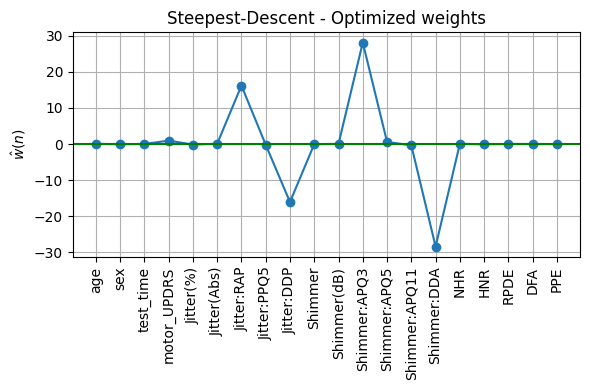

In [54]:
regressors = X_tr_norm
Nf = len(w_hat)
nn = np.arange(Nf)
plt.figure(figsize=(6, 4))
plt.plot(nn, w_hat, '-o')
ticks = nn
plt.xticks(ticks, regressors, rotation=90)
plt.ylabel(r'$\^w(n)$')
plt.title('Steepest-Descent - Optimized weights')
plt.grid()
plt.axhline(y=0, color='g')
plt.tight_layout()
plt.savefig('./SD-w_hat.png')
plt.show()

In [55]:
#we are intersted even in the dataset to evaluate possible overfitting
y_hat_te_norm = X_te_norm @ w_hat #regressand test vector
y_hat_tr_norm = X_tr_norm @ w_hat #regressand train vector

#denormalization of y_hat, because MSE has no sense with normalization (make data readable by doctors)
y_hat_tr = y_hat_tr_norm * sy + my
y_tr = y_tr_norm * sy + my
y_hat_te = y_hat_te_norm * sy + my
y_te = y_te_norm * sy + my

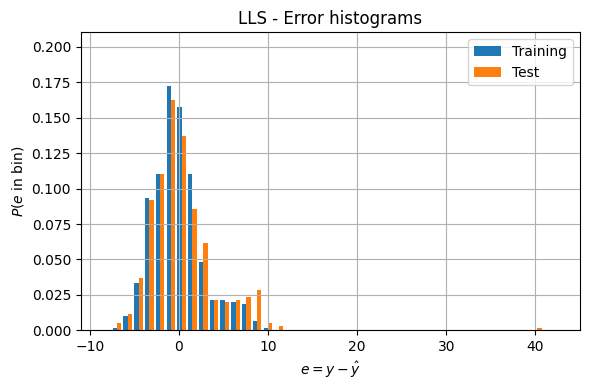

"The last plot shows that the error pdf is like a mixture of two gaussian pdfs. The fact that the two pdfs of training and test looks very similar is because there's no overfitting. It is said that the regression well generalize the dataset. If overfitting was present, the error in the training would have been more concentrated on the 0 value, while the pdf of the test would have depended on the similarity of the two datasets: if similar, the two pdfs would be similar, otherwise the result would be unpredictable"

In [56]:
# De-normalization, to make data readable by a medical doctor
E_tr = y_tr - y_hat_tr
E_te = y_te - y_hat_te
e = [E_tr, E_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Training', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.ylim([0, 0.21])
plt.xlim([-11, 45])
plt.grid()
plt.title('LLS - Error histograms')
plt.tight_layout()
plt.savefig('./LLS-Error-hist.png')
plt.show()

"""The last plot shows that the error pdf is like a mixture of two gaussian pdfs. The fact that the two pdfs of training and test looks very similar is because there's no overfitting. It is said that the regression well generalize the dataset. If overfitting was present, the error in the training would have been more concentrated on the 0 value, while the pdf of the test would have depended on the similarity of the two datasets: if similar, the two pdfs would be similar, otherwise the result would be unpredictable"""

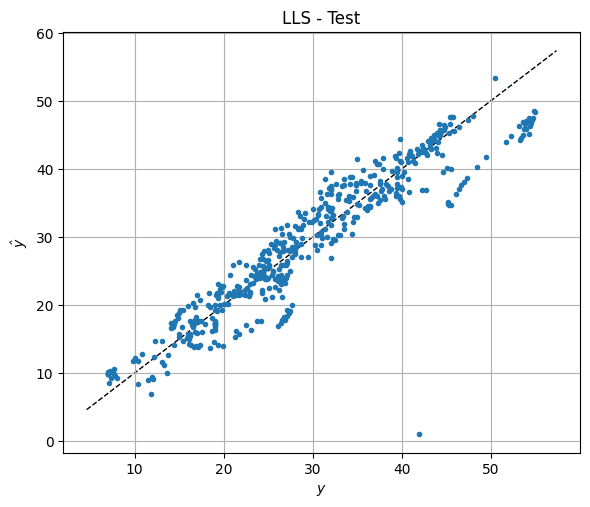

'The estimation is quite reliable, except for some cases that stay near 7-8 UPDRS points far from the original value. This justifies the second gaussian with its average near 7-8.'

In [57]:
y_hat_te = (X_te_norm @ w_hat) * sy + my
y_te = y_te_norm * sy + my
plt.figure(figsize=(6, 5))
plt.plot(y_te, y_hat_te, '.')
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'k--', linewidth=1, zorder=0)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.grid()
plt.tight_layout()
plt.title('LLS - Test')
plt.savefig('./LLS-yhat_vs_y.png')
plt.show()

"""The estimation is quite reliable, except for some cases that stay near 7-8 UPDRS points far from the original value. This justifies the second gaussian with its average near 7-8."""

In [58]:
#to represent results in a better form
E_tr_min = E_tr.min()
E_tr_max = E_tr.max()
E_tr_mu = E_tr.mean()
E_tr_sig = E_tr.std()
E_tr_MSE = np.mean(E_tr ** 2)
R2_tr = 1 - E_tr_MSE / np.var(y_tr)
c_tr = np.mean((y_tr - y_tr.mean()) * (y_hat_tr - y_hat_tr.mean())) / (y_tr.std() * y_hat_tr.std())
E_te_min = E_te.min()
E_te_max = E_te.max()
E_te_mu = E_te.mean()
E_te_sig = E_te.std()
E_te_MSE = np.mean(E_te ** 2)
R2_te = 1 - E_te_MSE / np.var(y_te)
c_te = np.mean((y_te - y_te.mean()) * (y_hat_te - y_hat_te.mean())) / (y_te.std() * y_hat_te.std())
rows = ['Training', 'Test']
cols = ['min', 'max', 'mean', 'std', 'MSE', 'R^2', 'correlation coefficient']
p = np.array([
    [E_tr_min, E_tr_max, E_tr_mu, E_tr_sig, E_tr_MSE, R2_tr, c_tr],
    [E_te_min, E_te_max, E_te_mu, E_te_sig, E_te_MSE, R2_te, c_te]
])
results = pd.DataFrame(p, columns=cols, index=rows)
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.max_rows', None)  # Mostra tutte le righe

print(results)

               min        max          mean       std        MSE       R^2  \
Training -7.503529  10.468688 -5.687751e-13  2.888472   8.326418  0.922054   
Test     -7.539036  40.810008  3.785802e-01  3.908652  15.390022  0.873411   

          correlation coefficient  
Training                 0.958296  
Test                     0.933397  
